# Machine Learning Contest
By: Kris Darnell & David Tang

01/31/17 Submission with feature enginering and stochastic gradient descent for MLP classifier. 
Contest is described [here](https://github.com/seg/2016-ml-contest).

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
from scipy.signal import medfilt

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# Loading Data
filename = 'facies_vectors.csv'  # Read in training data
training_data = pd.read_csv(filename)
training_data.fillna(training_data.mean(),inplace=True)  # Remove NaNs
training_data
filename = 'validation_data_nofacies.csv'  # Read in test well
validationFull = pd.read_csv(filename)

# Converts to category
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


**Do Feature Engineering**

In [2]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors

# Dictionary # enumerate puts out ind=0, label=SS, 
# and loops through the whole thing
facies_color_map = {}   
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
   
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(
        lambda row: label_facies(row, facies_labels), axis=1)

correct_facies_labels = training_data['Facies'].values
                                     
training_data.insert(1,'FormationNum',0)
validationFull.insert(1,'FormationNum',0)
training_data.insert(1,'FormationSH',0)
validationFull.insert(1,'FormationSH',0)

# Label Formations to differentiate between 'SH' and 'LM'
def is_SH(x):
    if 'SH' not in x:
        return 0
    else:
        return 1

# Convert formations to numerical values
for ii, formation in enumerate(training_data['Formation'].unique()):
    training_data.FormationNum[training_data.Formation == formation] = ii
    validationFull.FormationNum[validationFull.Formation == formation] = ii
    training_data.FormationSH = training_data.Formation.apply(is_SH)
    validationFull.FormationSH = validationFull.Formation.apply(is_SH)


wndw_sz = 30
dfs = []
for well in training_data['Well Name'].unique():
    df = training_data[training_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR', 'PHIND', 'ILD_log10', 'DeltaPHI']:
        # Rolling averages
        rollavg_col = 'rollavg_' + col
        df[rollavg_col] = df[col].rolling(window=wndw_sz, center=False).mean()
        df[rollavg_col].fillna(method='ffill', inplace=True)
        df[rollavg_col].fillna(method='bfill', inplace=True)
        
        # Compute features gradient
        grad_col = 'grad_' + col
        df[grad_col] = df[col].diff()
        df[grad_col].fillna(method='ffill', inplace=True)
        df[grad_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
training_data = pd.concat(dfs)
PE_mean = training_data.PE.mean()
roll_PE_mean = training_data.rollavg_PE.mean()
training_data['PE'] = training_data.PE.replace({np.nan: PE_mean})
training_data['rollavg_PE'] = training_data['rollavg_PE'].replace(
        {np.nan: roll_PE_mean})
feature_vectors = training_data.drop(['Well Name', 'Facies',
                                      'FaciesLabels', 'Formation'], axis=1)
feature_vectors.describe()

dfs = []
for well in validationFull['Well Name'].unique():
    df = validationFull[validationFull['Well Name'] == well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR', 'PHIND', 'ILD_log10', 'DeltaPHI']:
        rollavg_col = 'rollavg_' + col
        df[rollavg_col] = df[col].rolling(window=wndw_sz, center=False).mean()
        df[rollavg_col].fillna(method='ffill', inplace=True)
        df[rollavg_col].fillna(method='bfill', inplace=True)
        
        # Compute features gradient
        grad_col = 'grad_' + col
        df[grad_col] = df[col].diff()
        df[grad_col].fillna(method='ffill', inplace=True)
        df[grad_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
validationFull = pd.concat(dfs)
validationFull.describe()
validation = validationFull.drop(['Formation', 'Well Name'], axis=1)

X = feature_vectors.values
y = correct_facies_labels
well = training_data['Well Name'].values   


***
Make grid for cross validation

In [3]:
#alpha_grid = [1e-3, 1e-2, 2e-2, 3e-2, 1e-1]  
#solver_grid = ['sgd', 'lbfgs']  
#sizes_grid = [(100, 100), (200, 200), (200, 200, 100)]

alpha_grid = [0.1]  
solver_grid = ['sgd']  
sizes_grid = [(100, 100)]
param_grid = []
for alpha in alpha_grid:
    for solver in solver_grid:
        for sizes in sizes_grid:
                        param_grid.append({'alpha': alpha, 
                                           'solver': solver, 
                                           'sizes': sizes})

In [ ]:
# Initialize model selection methods
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut

lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=training_data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_labels)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_labels)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (training_data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (training_data['Well Name'][split['val']].unique()))

# Training Data

In [5]:
def train_and_test(X_tr, y_tr, X_v, well_v, param):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
#    scaler = preprocessing.StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    # Train classifier  
    clf = MLPClassifier(solver=param['solver'], 
                        alpha=param['alpha'], 
                        hidden_layer_sizes=param['sizes'], 
                        random_state=seed)

    clf.fit(X_tr, y_tr)
    
    # Make prediction
    y_v_hat = clf.predict(X_v)
#    plt.plot(y_v_hat)
#    plt.title('Before')
#    plt.show()

    
    # Perform median filter to smooth results
    k_size = 5
    if len(np.unique(well_v)) > 1:
        for w in np.unique(well_v):
            y_v_hat[well_v == w] = medfilt(y_v_hat[well_v == w], kernel_size=k_size)
    else:
        y_v_hat = medfilt(y_v_hat, kernel_size=k_size)
#    plt.plot(y_v_hat)
#    plt.title('After')
#    plt.show()

    
    return y_v_hat

In [6]:
# Do cross validation as an average across the leave p groups out splittin
seed = 200
np.random.seed(seed)

# For each set of parameters
score_param = []
for param in param_grid:
    
    # For each data split
    score_split = []
    for split in split_list:
    
        
        # Select training and validation data from current split
        X_tr = X[split['train'], :]
        X_v = X[split['val'], :]
        y_tr = y[split['train']]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v, param)
        
        # Score
        score = f1_score(y_v, y_v_hat, average='micro')
        score_split.append(score)
        
    # Average score for this param
    score_param.append(np.mean(score_split))
    print('F1 score = %.3f %s' % (score_param[-1], param))
          
# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

/Users/kdarnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


F1 score = 0.489 {'alpha': 0.1, 'sizes': (100, 100), 'solver': 'sgd'}

Best F1 score = 0.489 {'alpha': 0.1, 'sizes': (100, 100), 'solver': 'sgd'}


Retrain using the full dataset.

In [7]:
X_v = validation.values
well_v = validationFull['Well Name'].values
param = param_grid[best_idx]
validation_output = train_and_test(X, y, X_v, well_v, param)
validationFull['Facies'] = validation_output

/Users/kdarnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


## Apply to test well

In [13]:
validationFull.to_csv('TangDarnell_sub7.csv')

In [14]:
logo = LeaveOneGroupOut()        
all_scores = []
for train, test in logo.split(X, y, groups=well):
    well_name = well[test[0]]
    
    # Select training and validation data from current split
    X_tr = X[train,:]
    X_v = X[test,:]
    y_tr = y[train]
    y_v = y[test]
               
    # Train and test
    y_out= train_and_test(X_tr, y_tr, X_v, well_name, param)

    score = f1_score(y_out, y[test], average='micro')
    all_scores.append(score)
    print("{:>20s}  {:.3f}".format(well_name, score))
all_scores = np.asarray(all_scores)
print("Average F1 score is: {:.3f}".format(all_scores.mean()))

/Users/kdarnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


         ALEXANDER D  0.536
     CHURCHMAN BIBLE  0.547
      CROSS H CATTLE  0.353
            KIMZEY A  0.458
            LUKE G U  0.525
               NEWBY  0.471
               NOLAN  0.480
          Recruit F9  0.850
             SHANKLE  0.526
           SHRIMPLIN  0.480
Average F1 score is: 0.523


In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
def make_facies_log_plot(logs, facies_colors):
   #make sure logs are sorted by depth
   logs = logs.sort_values(by='Depth')
   cmap_facies = colors.ListedColormap(
           facies_colors[0:len(facies_colors)], 'indexed')
   
   ztop=logs.Depth.min(); zbot=logs.Depth.max()
   
   cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1) # Makes it a nx1, repeating values along an dimension
   
   f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
   ax[0].plot(logs.GR, logs.Depth, '-g')
   ax[1].plot(logs.ILD_log10, logs.Depth, '-')
   ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
   ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
   ax[4].plot(logs.PE, logs.Depth, '-', color='black')
   im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=9)
   
   divider = make_axes_locatable(ax[5])
   cax = divider.append_axes("right", size="20%", pad=0.05)
   cbar=plt.colorbar(im, cax=cax)
   cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                               'SiSh', ' MS ', ' WS ', ' D  ', 
                               ' PS ', ' BS ']))
   cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
   
   for i in range(len(ax)-1):
       ax[i].set_ylim(ztop,zbot)
       ax[i].invert_yaxis()
       ax[i].grid()
       ax[i].locator_params(axis='x', nbins=3)
   
   ax[0].set_xlabel("GR")
   ax[0].set_xlim(logs.GR.min(),logs.GR.max())
   ax[1].set_xlabel("ILD_log10")
   ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
   ax[2].set_xlabel("DeltaPHI")
   ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
   ax[3].set_xlabel("PHIND")
   ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
   ax[4].set_xlabel("PE")
   ax[4].set_xlim(logs.PE.min(),logs.PE.max())
   ax[5].set_xlabel('Facies')
   
   ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
   ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
   ax[5].set_xticklabels([])
   f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


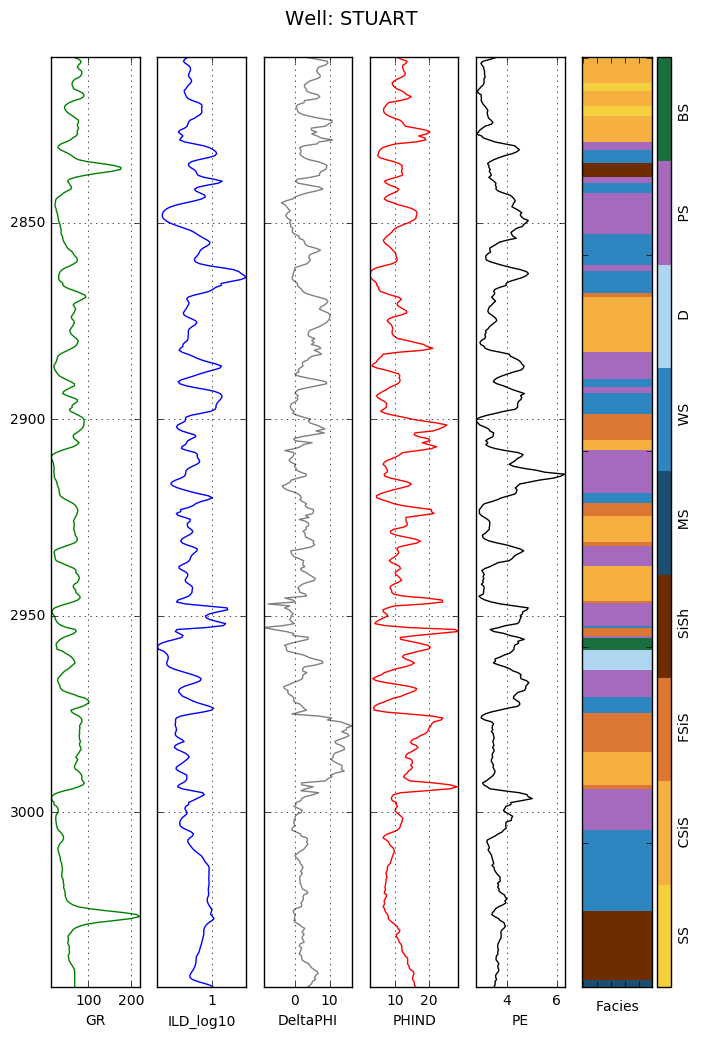

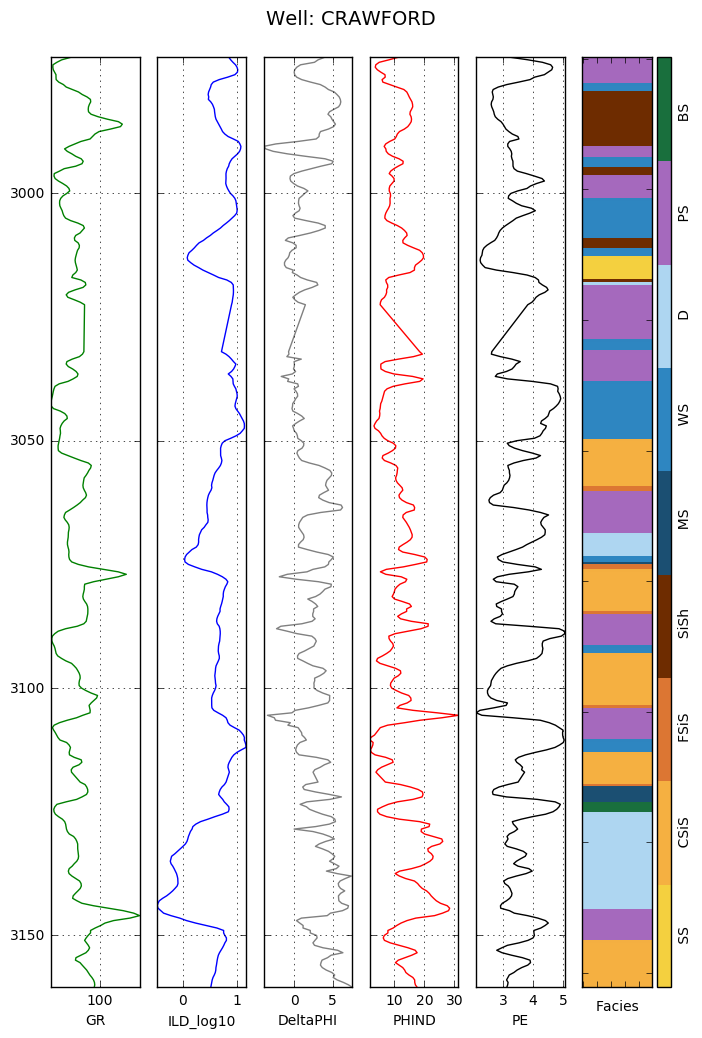

In [16]:
get_ipython().magic('matplotlib inline')
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='STUART'],
    facies_colors=facies_colors)
make_facies_log_plot(
    validationFull[validationFull['Well Name']=='CRAWFORD'],
    facies_colors=facies_colors)
